In [14]:
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import math 
import matplotlib.pyplot as plt 

In [15]:
df= pd.read_csv('C:/Users/sid31/Downloads/New folder/semester 2/machine learning/python exercises/regression/housing.csv')


In [27]:
k = df.values
k[9,:]

array([2.2489e-01, 1.2500e+01, 7.8700e+00, 0.0000e+00, 5.2400e-01,
       6.3770e+00, 9.4300e+01, 6.3467e+00, 5.0000e+00, 3.1100e+02,
       1.5200e+01, 3.9252e+02, 2.0450e+01, 1.5000e+01])

In [33]:
class Regressor:
    def __init__(self, X, y, tol , learning_rate, iterations, reg_param,SGDiterations, gd= False, regp = False, sgd = False):
        self.X = X
        self.y = y
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.tol = tol 
        #self.m , self.n = self.X.shape
        self.gd = gd
        self.iterations_count = []
        self.error_seq = []
        self.reg_param = reg_param
        self.regp = regp
        self.sgd = sgd
        self.SGDiterations = SGDiterations
        
    def trainTestSplit(self):
        x_train , x_test, y_train, y_test = train_test_split(self.X,self.y, test_size = 0.3, random_state = 0)
        return x_train , x_test, y_train, y_test
    
    def addBias(self,X):
        return np.column_stack([np.ones((X.shape[0],1)),X])
    
    def normData(self,X):
        mean = np.mean(X, 0)
        std =  np.std(X , 0)
        nor =  ( X - mean) / std
        x_norm = self.addBias(nor)
        return x_norm, mean, std # retrun std and mean so that you need to normalise test data on this mean and std 
    
    def normTestData(self, X, TrainMean, TrainStd):
        x_norm = ( X - TrainMean ) / TrainStd
        x_norm = self.addBias(x_norm)
        return x_norm
    
    # closed form or normal equation 
    # find rank of the matrix to see full rank to evaluate invertibility 
    
    def rank(self, X, esp = 1e-21):
        u ,s ,vh = np.linalg.svd(X)
        # s is diagonol matrix - if all values of s are not 0 and >0 we are good 
        
        return len([x for x in s if abs(s) > esp])
    # anathor way to check the rnak of matix
    def checkMatrix(self,X):
        
        x_rank  = np.linalg.matrix_rank(X)
        if x_rank == min(X.shape[0], X.shape[1]):
            self.fullRank = True
            print('Data is full rank')
        else:
            self.fullRank = False
            print('Data not full rank')
            
    def checkInvertibility(self,X):
        if X.shape[0] < X.shape[1]:
            self.lowRank = True
            print('Data is low rank')
        else:
            self.lowRank = False
            print('Data is not low rank')
    
    def normalEq(self,X,y):
        w = np.linalg.inv(np.dot(X.T,X)).dot(X.T).dot(y)
        return w
    
    def regNormalEquation(self,X,y):
        w = np.linalg.inv( np.dot(X.T,X) + self.reg_param * ( np.identity(X.shape[1]) )  ).dot(X.T).dot(y)
        return w
    
    
    def gradientDescent(self,X,y):
        #error_seq = []
        prev_error = float('inf')
        
        for t in tqdm(range(self.iterations)):
            self.w = self.w - self.learning_rate * self.costDerivative(X,y)
            cur = self.rmse(X,y)
            diff = prev_error - cur
            prev_error = cur
            self.error_seq.append(cur)
            self.iterations_count.append(t)
            
            if diff < self.tol: # in real life you need to wait patience* until certain iterations before you break
                print("model stopped - no further updating")
                break          
                
    def regGradientDescent(self, X,y):
        
        prev_error = float('inf')
        
        for t in tqdm(range(self.iterations)):
            w_update = self.w * (1 - self.learning_rate *( self.reg_param / X.shape[0]))
            self.w  = w_update - (self.learning_rate  * self.regCostDerivative(X,y))  
            cur = self.rmse(X,y)
            diff = prev_error - cur
            prev_error = cur
            self.error_seq.append(cur)
            self.iterations_count.append(t)
            
            if diff < self.tol: # in real life you need to wait patience* until certain iterations before you break
                print("model stopped - no further updating")
                break
                
    def sgradientDescent(self, X, y ):
        prev_error = float('inf')
        
        for t in tqdm(range(self.SGDiterations)):
            for i in range(X.shape[0]):
                self.W = self.w - self.learning_rate * self.costDerivative(X[i],y[i])
                cur = self.rmse(X[i],y[i])
                diff = prev_error - cur
                prev_error = cur
                self.error_seq.append(cur)
                self.iterations_count.append(t)
        
    def regSGradientDescent():
        prev_error = float('inf')
        
        for t in tqdm(range(self.SGDiterations)):
            for i in range(X.shape[0]):
                w_update = self.w * (1 - self.learning_rate *( self.reg_param / X.shape[0]))
                self.w  = w_update - (self.learning_rate  * self.regCostDerivative(X[i],y[i]))
                #self.W = slef.w - self.learning_rate * self.costDerivative(X[i,:],y[i,1])
                cur = self.rmse(X[i],y[i])
                diff = prev_error - cur
                prev_error = cur
                self.error_seq.append(cur)
                self.iterations_count.append(t)
        
            
    def sse(self,X,y):
        y_hat = self.predict(X)
        return ((y_hat - y)**2).sum()
    
    def rmse(self,X,y):
        dum = self.sse(X,y)
        return np.sqrt(dum / X.shape[0])
    
    def predict(self,X):
        return X.dot(self.w)
    
    def costFunc(self,X, y):
        return self.sse(X,y)/2
    
    def regCostFunc(self,X,y):
        return ( self.sse(X,y) + (self.reg_param * np.dot(X.T,X).sum()) ) / 2
    
    def costDerivative(self,X,y):
        y_hat = self.predict(X)
        return np.dot(y_hat - y , X)
    
    def regCostDerivative(self,X,y):
        y_hat = self.predict(X)
        return np.dot(y_hat - y , X) / X.shape[0]
    
    
    def fit(self):
        self.x_train , self.x_test, self.y_train, self.y_test = self.trainTestSplit()
        self.x_train, self.mean, self.std = self.normData(self.x_train)
        self.x_test = self.normTestData(self.x_test, self.mean, self.std)
        
        self.checkMatrix(self.x_train)
        self.checkInvertibility(self.x_train)
        
        if self.fullRank and not self.lowRank and not self.gd and not self.sgd:
            print("solving using normal equation...")
            if not self.regp:
                print("without regularisation")
                self.w = self.normalEq(self.x_train, self.y_train)
                
            else: 
                print("with regularisation")
                self.w = self.regNormalEquation(self.x_train, self.y_train)
            
        elif not self.sgd: 
            print("solving using gradient descent...")
            self.w = np.ones(self.x_train.shape[1], dtype = np.float64) *0
            
            if not self.regp:
                print("without regularisation ")
                self.gradientDescent(self.x_train,self.y_train)
                
            else: 
                print("with regularisation")
                self.regGradientDescent(self.x_train,self.y_train)
                
        else: 
            print("solving using stochastic gradient descent...")
            self.w = np.ones(self.x_train.shape[1], dtype = np.float64) *0
            
            if not self.regp:
                print("without regularisation ")
                
                self.sgradientDescent(self.x_train,self.y_train)
                
            else: 
                print("with regularisation")
                self.regSGradientDescent(self.x_train,self.y_train)
                
                
            
        print(self.w)
        
    def plotError(self, figsize=(7,5)):
        
        plt.figure(figsize=figsize)
        plt.plot(self.iterations_count,self.error_seq)
        plt.xlabel('Iterations')
        plt.ylabel('Cost')
        plt.title("Iterations vs Cost")
        plt.show()
        
    def score(self,X,y):
        return 1-(np.sum(((y-self.predict(X))**2))/np.sum((y-np.mean(y))**2))
        
        

Data is full rank
Data is not low rank
solving using stochastic gradient descent...
without regularisation 


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 157.37it/s]

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


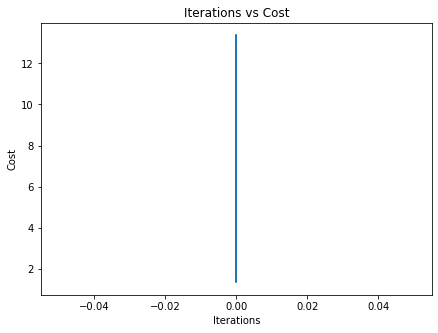

In [36]:
reg = Regressor(df.values[:,0:-1], df.values[:,-1], learning_rate= 0.0004, tol = 0.005, iterations = 50000, 
                SGDiterations = 1,reg_param = 0.03
               , gd = False, regp = False, sgd = True )
reg.fit()
reg.plotError()

In [35]:
reg.score(reg.x_test,reg.y_test)

-5.922879732152989

In [59]:
df1 = pd.read_csv('C:/Users/sid31/Downloads/New folder/semester 2/machine learning/python exercises/concreteData.csv')

Data is full rank
Data is not low rank
solving using gradient descent...
without regularisation 


  0%|▏                                                                          | 140/50000 [00:00<00:01, 40191.82it/s]

model stopped - no further updating
[35.55869444 12.44770816  8.66659059  5.53272991 -2.91503991  2.06868838
  1.26049025  1.15047029  7.34790782]


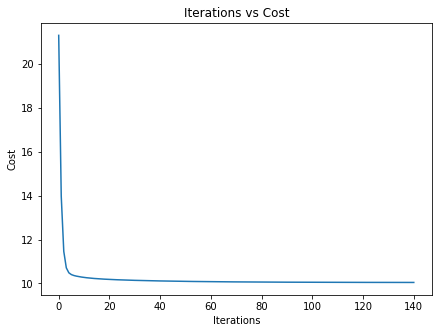

In [79]:
reg1 = Regressor(df1.values[:,0:-1], df1.values[:,-1], learning_rate= 0.0007, tol = 0.0001, iterations = 50000,
                 SGDiterations = 10, reg_param = 0.03
               , gd = True, regp = False, sdg = True)
reg1.fit()
reg1.plotError()

In [80]:
reg1.score(reg1.x_test,reg1.y_test)

0.5309870713796991

In [68]:
df2 = pd.read_csv('C:/Users/sid31/Downloads/New folder/semester 2/machine learning/python exercises/yachtData.csv')

Data is full rank
Data is not low rank
solving using gradient descent...
without regularisation 


  0%|                                                                            | 19/50000 [00:00<00:01, 36108.64it/s]

model stopped - no further updating
[10.65570116  0.54860892 -0.64086545 -0.1248648  -0.05651829 -0.2141502
 12.78556211]


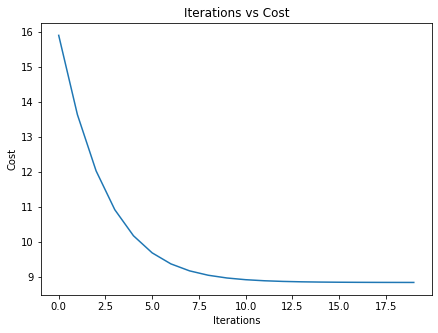

In [81]:
reg2 = Regressor(df2.values[:,0:-1], df2.values[:,-1], learning_rate= 0.001, tol = 0.001, iterations = 50000, reg_param = 0.03
               , gd = True, regp = False)
reg2.fit()
reg2.plotError()

In [82]:
reg2.score(reg2.x_test,reg2.y_test)

0.5774229134496307